In [1]:
# The code was removed by Watson Studio for sharing.

# The Battle of Neighborhoods

## 1. Introduction 

   One of my friend is going to Chicago for his grad school, and now he is stuggling with fiding a new apartment around the school. He has some basic requirements of the new apartment in Chicago. They are:
   1. The price of the apartment has to be affordable (around $3K/mo.).
   2. It has to be less than 20 mins away (around 0.6 miles, or 1 km) from the subway station by walking. 
   3. He prefers the neighborhood of his new apartment is similar to the neighborhood of his home in Queens, NY.
 
Based on his requirements above, I'm planning to help him find a new accomodation in Chicago by using data analysis techniques. 


## 2. Data

### 2.1 Acquiring Data


   The address of my friend's home is in 'Flushing, NY'. This address will be the input to the FourSquare API, and the output will be all the venues around this address, with coordinates. These venues will be stored into a dataframe, called 'homeVenues'. Then, for the neighborhoods in Chicago, it can be found on the Wikipeida website 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago. The subway location data can be found in a dataframe, and the coordinates are already provided, 'https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme/data'. It can be easily acquired by using API provided on this website. The data of rental apartments avaliable in Chicago will be scraped from a rental website by using the local Python compiler. The data will be stored in a CSV file, which will be uploaded directly to the IBM Watson Studio. For all the coordinates data, it can be found by using the 'geopy.geocoders package'. With all these data, the data processing and analyzing procedure can be moved on. 
   

The process of acquiring data is shown below. 

#### 2.1.1 Get 'homeVenues' Data with FourSquare API 

In [2]:
import numpy as np
import pandas as pd
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
home='Flushing, NY'
geolocator = Nominatim()
location = geolocator.geocode(home)
print(location)
homeLati=location.latitude
homeLongi=location.longitude
print(homeLati)
print(homeLongi)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


Flushing, Queens, New York, Queens County, New York, 11354, United States of America
40.7654301
-73.8174291


In [5]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    homeLati, 
    homeLongi, 
    radius, 
    LIMIT)
venue_results = requests.get(url).json()
Venues = venue_results['response']['groups'][0]['items']
#Venues

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
homeVenues = json_normalize(Venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
homeVenues =homeVenues.loc[:, filtered_columns]
# filter the category for each row
homeVenues['venue.categories'] = homeVenues.apply(get_category_type, axis=1)
# clean columns
homeVenues.columns = [col.split(".")[-1] for col in homeVenues.columns]
print('The shape of \'homeVenues\' is: ', homeVenues.shape)
homeVenues.head()

The shape of 'homeVenues' is:  (46, 4)


,name,categories,lat,lng
0,NY Puppy Club,Pet Service,40.765407,-73.817102
1,"Voelker Orth Museum, Bird Sanctuary and Victor...",History Museum,40.763886,-73.819388
2,Hahm Ji Bach - 함지박,Korean Restaurant,40.763022,-73.815042
3,Butcher's Cut,Korean Restaurant,40.765190,-73.820273
4,Kum Sung Chik Naengmyun,Korean Restaurant,40.763122,-73.815091


#### 2.1.2 Get Chicago Neighborhoods Data from Wikipedia

In [8]:
# Scrape neighborhood data from Wikipedia
dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago')
#for i in range(0, len(dfs)):
    
    #print(dfs[i])

In [9]:
ChicagoHoods=dfs[0]
ChicagoHoods.columns=['Neighborhood', 'Borough']
print('The shape of \'ChicagoHoods\' is: ', ChicagoHoods.shape)
ChicagoHoods.head()

The shape of 'ChicagoHoods' is:  (246, 2)


,Neighborhood,Borough
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [10]:
# add coordinates by looping the geolocator 

Lat=[]
Lgt=[]
count=1
for a in ChicagoHoods['Neighborhood']:
    address=a+', Chicago, IL'
    geolocator = Nominatim(user_agent="a")
    location = geolocator.geocode(address)
    if location==None:
        latitude=None
        longitude=None
    else:
        latitude = location.latitude
        longitude = location.longitude
    Lat.append(latitude)
    Lgt.append(longitude)
    
ChicagoHoods['Latitude']=Lat
ChicagoHoods['Longitude']=Lgt

ChicagoHoods.head()

,Neighborhood,Borough,Latitude,Longitude
0,Albany Park,Albany Park,41.971937,-87.716174
1,Altgeld Gardens,Riverdale,41.654864,-87.600446
2,Andersonville,Edgewater,41.977139,-87.669273
3,Archer Heights,Archer Heights,41.811422,-87.726165
4,Armour Square,Armour Square,41.840033,-87.633107


#### 2.1.3 Get Chicago Subway Stops Data with Chicago Data Portal API

In [11]:
# Use API to load subway data
api='https://data.cityofchicago.org/resource/8pix-ypme.json'
results = requests.get(api).json()
#results

In [12]:
subway_full_data = json_normalize(results)
subway_full_data.head()

,:@computed_region_43wa_7qmu,:@computed_region_6mkv_f3dw,:@computed_region_awaf_s7ux,:@computed_region_bdys_3d7i,:@computed_region_vrxf_vc4k,ada,blue,brn,direction_id,g,...,o,p,pexp,pnk,red,station_descriptive_name,station_name,stop_id,stop_name,y
0,26,14920,8,343,33,True,False,False,W,False,...,False,False,False,True,False,18th (Pink Line),18th,30162,18th (54th/Cermak-bound),False
1,26,14920,8,343,33,True,False,False,E,False,...,False,False,False,True,False,18th (Pink Line),18th,30161,18th (Loop-bound),False
2,1,14924,26,719,56,True,False,False,N,False,...,True,False,False,False,False,35th/Archer (Orange Line),35th/Archer,30022,35th/Archer (Loop-bound),False
3,1,14924,26,719,56,True,False,False,S,False,...,True,False,False,False,False,35th/Archer (Orange Line),35th/Archer,30023,35th/Archer (Midway-bound),False
4,9,21194,12,25,1,True,False,False,S,True,...,False,False,False,False,False,35th-Bronzeville-IIT (Green Line),35th-Bronzeville-IIT,30214,35-Bronzeville-IIT (63rd-bound),False


In [13]:
subway_full_data.columns

Index([':@computed_region_43wa_7qmu', ':@computed_region_6mkv_f3dw',
       ':@computed_region_awaf_s7ux', ':@computed_region_bdys_3d7i',
       ':@computed_region_vrxf_vc4k', 'ada', 'blue', 'brn', 'direction_id',
       'g', 'location.latitude', 'location.longitude', 'map_id', 'o', 'p',
       'pexp', 'pnk', 'red', 'station_descriptive_name', 'station_name',
       'stop_id', 'stop_name', 'y'],
      dtype='object')

In [14]:
subway=subway_full_data[['stop_id','stop_name','location.latitude','location.longitude']]
subway.columns=['stopID','stopName', 'latitude', 'longitude']
print('The shape of \'subway\' is: ', subway.shape)
subway.head()

The shape of 'subway' is:  (300, 4)


,stopID,stopName,latitude,longitude
0,30162,18th (54th/Cermak-bound),41.857908,-87.669147
1,30161,18th (Loop-bound),41.857908,-87.669147
2,30022,35th/Archer (Loop-bound),41.829353,-87.680622
3,30023,35th/Archer (Midway-bound),41.829353,-87.680622
4,30214,35-Bronzeville-IIT (63rd-bound),41.831677,-87.625826


#### 2.1.4 Acquire Rental Data

In [15]:
# The code was removed by Watson Studio for sharing.

The shape of 'ChicagoApt' is:  (92, 3)


,name,address,price
0,One East Delaware,"1 E Delaware Pl, Chicago, IL 60611, USA",$2346
1,MILA Luxury Apartments,"201 N Garland Ct, Chicago, IL 60601, USA",$1805
2,1133 n dearborn,"1133 N Dearborn St, Chicago, IL 60610, USA",$1566
3,One Superior Place,"1 W Superior St, Chicago, IL 60654, USA",$1572
4,1350 N Lakeshore Dr,"1350 N Lake Shore Dr, Chicago, IL 60610, USA",$1528


In [16]:
# add coordinates by looping the geolocator

lat=[]
long=[]
geolocator = Nominatim()

for i in range (0, len(ChicagoApt.address)):
    #print(i, ChicagoApt.address[i])
    location = geolocator.geocode(ChicagoApt.address[i])
    if location==None:
        latitude=None
        longitude=None
        #print("none")
    else:
        lati = location.latitude
        longi = location.longitude
        #print(lati,'', longi)
    lat.append(lati)
    long.append(longi)
#print(len(lat), ' ', len(long))
ChicagoApt['latitude']=lat
ChicagoApt['longitude']=long
ChicagoApt.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


,name,address,price,latitude,longitude
0,One East Delaware,"1 E Delaware Pl, Chicago, IL 60611, USA",$2346,41.898904,-87.627970
1,MILA Luxury Apartments,"201 N Garland Ct, Chicago, IL 60601, USA",$1805,41.885865,-87.625151
2,1133 n dearborn,"1133 N Dearborn St, Chicago, IL 60610, USA",$1566,41.902828,-87.629514
3,One Superior Place,"1 W Superior St, Chicago, IL 60654, USA",$1572,41.895493,-87.629008
4,1350 N Lakeshore Dr,"1350 N Lake Shore Dr, Chicago, IL 60610, USA",$1528,41.907101,-87.626414


### 2.2 Cleaning Data

As shown above, there is some missing information in 'ChicagoHoods' and 'ChicagoApt' datasets, especially the missing latitude and longitude. I will delete  the whole row containing the missing entry. For dataset called 'sbuway', there are some repeated latitudes and longitudes. I'll delete the repeated information.

In [17]:
ChicagoHoods=ChicagoHoods.dropna(axis=0)
ChicagoHoods.reset_index(drop=True)
print('The shape of cleaned \'ChicagoHoods\' is: ', ChicagoHoods.shape)
ChicagoHoods.head()

The shape of cleaned 'ChicagoHoods' is:  (231, 4)


,Neighborhood,Borough,Latitude,Longitude
0,Albany Park,Albany Park,41.971937,-87.716174
1,Altgeld Gardens,Riverdale,41.654864,-87.600446
2,Andersonville,Edgewater,41.977139,-87.669273
3,Archer Heights,Archer Heights,41.811422,-87.726165
4,Armour Square,Armour Square,41.840033,-87.633107


In [18]:
ChicagoApt=ChicagoApt.dropna(axis=0)
ChicagoApt.reset_index(drop=True)
print('The shape of cleaned \'ChicagoApt\' is: ', ChicagoApt.shape)
ChicagoApt.head()

The shape of cleaned 'ChicagoApt' is:  (92, 5)


,name,address,price,latitude,longitude
0,One East Delaware,"1 E Delaware Pl, Chicago, IL 60611, USA",$2346,41.898904,-87.627970
1,MILA Luxury Apartments,"201 N Garland Ct, Chicago, IL 60601, USA",$1805,41.885865,-87.625151
2,1133 n dearborn,"1133 N Dearborn St, Chicago, IL 60610, USA",$1566,41.902828,-87.629514
3,One Superior Place,"1 W Superior St, Chicago, IL 60654, USA",$1572,41.895493,-87.629008
4,1350 N Lakeshore Dr,"1350 N Lake Shore Dr, Chicago, IL 60610, USA",$1528,41.907101,-87.626414


In [19]:
subway.head()

,stopID,stopName,latitude,longitude
0,30162,18th (54th/Cermak-bound),41.857908,-87.669147
1,30161,18th (Loop-bound),41.857908,-87.669147
2,30022,35th/Archer (Loop-bound),41.829353,-87.680622
3,30023,35th/Archer (Midway-bound),41.829353,-87.680622
4,30214,35-Bronzeville-IIT (63rd-bound),41.831677,-87.625826


In [20]:
df=subway
coordinates=[]
for i in range (0, df.shape[0]):
    coordinates.append(df.iloc[i][2]+df.iloc[i][3])
df["co"]=coordinates
df2=df
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,stopID,stopName,latitude,longitude,co
0,30162,18th (54th/Cermak-bound),41.857908,-87.669147,41.857908-87.669147
1,30161,18th (Loop-bound),41.857908,-87.669147,41.857908-87.669147
2,30022,35th/Archer (Loop-bound),41.829353,-87.680622,41.829353-87.680622
3,30023,35th/Archer (Midway-bound),41.829353,-87.680622,41.829353-87.680622
4,30214,35-Bronzeville-IIT (63rd-bound),41.831677,-87.625826,41.831677-87.625826


In [21]:
column_names=['stopID', 'stopName', 'latitude', 'longitude', 'co']
df3 = pd.DataFrame(columns = column_names)
df3

,stopID,stopName,latitude,longitude,co


In [22]:
for i in range (0, 300):
    #print('i= ', i, end=' ')
    count=0
    if i==0:
        row_df=pd.DataFrame([df.iloc[i]])
        df3=pd.concat([row_df,df3], ignore_index=True)
    else:
        for j in range (0, i):
            #print("       j= ", j )
            if df.iloc[i][4]==df2.iloc[j][4]:
                count+=1
                #print('            count= ', count)
        if count==0:
            row_df=pd.DataFrame([df.iloc[i]])
            df3=pd.concat([row_df,df3], ignore_index=True)
    #print('\n')
                    
subway=df3.drop(['co'], axis=1)
subway['latitude'] = subway['latitude'].astype(float)
subway['longitude'] = subway['longitude'].astype(float)
print("The shape of cleaned \'subway\' is: ", subway.shape)
subway.head()

The shape of cleaned 'subway' is:  (144, 4)


,stopID,stopName,latitude,longitude
0,30385,Wilson (Loop-bound),41.964273,-87.657588
1,30042,Western (Forest Pk Branch) (O'Hare-bound),41.875478,-87.688436
2,30130,Western (O'Hare Branch) (Forest Pk-bound),41.916157,-87.687364
3,30283,Western (Kimball-bound),41.966163,-87.688502
4,30144,Western (54th/Cermak-bound),41.854225,-87.685129


### 2.3 Data Stats

## 3. Methodology

After acquiring all the data, the problem can be solved step by step. First, with the neighborhood data and the FourSquare API, the top ten venues for all Chicago neighborhoods  can be found. Then all these neighborhoods can be grouped into different clusters according to the venuees in this neighborhoods. Second, the subway data and the apartments data can be plot on the map in order to find the apartments avaliable within 0.6 miles/1km distance to the subway stations. Third, by compairing with the venues in different neighborhoods and the venues around home, the best matching neighborhoods can ba defined. Fourth, some best matching apartments can be determined by compairing the distance to the subway stations and the neighborhoods where these apartments locate. 

### 3.1 Find the top 10 venues in each neighborhood in Chicago

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
ChicagoVenues = getNearbyVenues(names=ChicagoHoods['Neighborhood'],
                                   latitudes=ChicagoHoods['Latitude'],
                                   longitudes=ChicagoHoods['Longitude']
                                  )
print('The shape of \'ChicagoVenues\' is: ', ChicagoVenues.shape)
print('There are {} uniques categories.'.format(len(ChicagoVenues['Venue Category'].unique())))
ChicagoVenues.head()

The shape of 'ChicagoVenues' is:  (5792, 7)
There are 345 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany Park,41.971937,-87.716174,Cairo Nights Hookah Lounge,41.975776,-87.715547,Hookah Bar
1,Albany Park,41.971937,-87.716174,Nighthawk,41.967974,-87.713415,Cocktail Bar
2,Albany Park,41.971937,-87.716174,Chicago Produce,41.970553,-87.716327,Grocery Store
3,Albany Park,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
4,Albany Park,41.971937,-87.716174,Markellos Baking Company,41.968602,-87.716607,Bakery


In [25]:
# one hot encoding
chicago_onehot = pd.get_dummies(ChicagoVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = ChicagoVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
print('The shape of \'chicago_onehot\' is:', chicago_onehot.shape)
chicago_onehot.head()

The shape of 'chicago_onehot' is: (5792, 346)


,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Vineyard,Warehouse Store,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
print('The shape of \'chicago_grouped\' is:', chicago_grouped.shape)
chicago_grouped.head()

The shape of 'chicago_grouped' is: (229, 346)


,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Vineyard,Warehouse Store,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,Altgeld Gardens,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,Andersonville,0.0,0.0,0.014286,0.0,0.0,0.0,0.0,0.014286,0.0,...,0.0,0.0,0.0,0.0,0.014286,0.0,0.014286,0.000000,0.0,0.0
3,Archer Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.0,0.0
4,Armour Square,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [58]:
num_top_venues = 10

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Grocery Store,Fried Chicken Joint,Bus Station,Donut Shop,Bakery,Mobile Phone Shop,Korean Restaurant,Chinese Restaurant,Diner,Cocktail Bar
1,Altgeld Gardens,Park,Fast Food Restaurant,Yoga Studio,Event Space,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
2,Andersonville,Pet Store,Korean Restaurant,Burger Joint,Bookstore,Comic Shop,Coffee Shop,Pizza Place,Breakfast Spot,Spa,Bakery
3,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Bank,Wings Joint,Gas Station,Optical Shop,Sandwich Place,Coffee Shop,Bar
4,Armour Square,Chinese Restaurant,Sandwich Place,Hot Dog Joint,Cosmetics Shop,Gas Station,Coffee Shop,Italian Restaurant,Asian Restaurant,Event Service,Drugstore


### 3.2 Clustering Neighborhoods in Chicago with K-Means

According to the map of all the neighborhoods in Chicago, it's hard to tell the K-value of K-Means Clustering. Then, after examing the inaccuracy of different K-values in range (1, 50), there is no elbow point in the inaccuracy plot. Therefore, it's inappropriate to use K-Means to cluster neighborhoogs in Chicago. 

In [28]:
city="Chicago, IL"
geolocator = Nominatim()
location = geolocator.geocode(city)
print(location)
cityLati=location.latitude
cityLongi=location.longitude
print(cityLati)
print(cityLongi)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


Chicago, Cook County, Illinois, United States of America
41.8755616
-87.6244212


In [29]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.0-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


folium-0.5.0         | 45 KB     | ##################################### | 1

In [30]:
import matplotlib.pyplot as plt  
from matplotlib import style 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.cm as cm
import matplotlib.colors as colors

In [31]:
map_Chicago = folium.Map(location=[cityLati, cityLongi], zoom_start=10)

for lat, lng, borough, neighborhood in zip(ChicagoHoods['Latitude'], ChicagoHoods['Longitude']
                                           , ChicagoHoods['Borough'], ChicagoHoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Chicago)  
    
map_Chicago

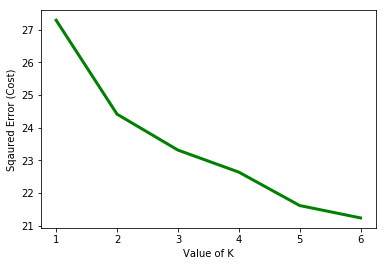

In [129]:
chicago_clustering=chicago_grouped.drop('Neighborhood', 1)
    

cost =[] 
labels=[]
for i in range(1, 7): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(chicago_clustering)
    labels.append(KM.labels_)
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 7), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [130]:
num_top_venues = 10

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

In [131]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels[4])

chicago_merged = ChicagoHoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
chicago_merged=chicago_merged.dropna(axis=0)
chicago_merged.reset_index(drop=True)
chicago_merged

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Albany Park,41.971937,-87.716174,4.0,Grocery Store,Fried Chicken Joint,Bus Station,Donut Shop,Bakery,Mobile Phone Shop,Korean Restaurant,Chinese Restaurant,Diner,Cocktail Bar
1,Altgeld Gardens,Riverdale,41.654864,-87.600446,3.0,Park,Fast Food Restaurant,Yoga Studio,Event Space,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
2,Andersonville,Edgewater,41.977139,-87.669273,4.0,Pet Store,Korean Restaurant,Burger Joint,Bookstore,Comic Shop,Coffee Shop,Pizza Place,Breakfast Spot,Spa,Bakery
3,Archer Heights,Archer Heights,41.811422,-87.726165,0.0,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Bank,Wings Joint,Gas Station,Optical Shop,Sandwich Place,Coffee Shop,Bar
4,Armour Square,Armour Square,41.840033,-87.633107,4.0,Chinese Restaurant,Sandwich Place,Hot Dog Joint,Cosmetics Shop,Gas Station,Coffee Shop,Italian Restaurant,Asian Restaurant,Event Service,Drugstore
5,Ashburn,Ashburn,41.747533,-87.711163,4.0,Italian Restaurant,Automotive Shop,Cosmetics Shop,Light Rail Station,Exhibit,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
7,Auburn Gresham,Auburn Gresham,41.743387,-87.656042,3.0,Park,Discount Store,Basketball Court,Yoga Studio,Event Space,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
8,Avalon Park,Avalon Park,41.745035,-87.588658,4.0,Burger Joint,Fast Food Restaurant,ATM,Grocery Store,Diner,Sandwich Place,Cajun / Creole Restaurant,Business Service,Boutique,Food
9,Avondale,Avondale,41.938921,-87.711168,4.0,Grocery Store,Park,Chinese Restaurant,Food Truck,Gym,Supermarket,Storage Facility,Rental Car Location,Korean Restaurant,Bar
10,Avondale Gardens,Irving Park,41.938921,-87.711168,4.0,Grocery Store,Park,Chinese Restaurant,Food Truck,Gym,Supermarket,Storage Facility,Rental Car Location,Korean Restaurant,Bar


In [132]:
chicago_merged['Cluster Labels']=chicago_merged['Cluster Labels'].astype(int)

In [ ]:
map_clusters = folium.Map(location=[cityLati, cityLongi], zoom_start=11)
k=5
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.3 Compare homeVenue with Neighborhood Clusters

By compairing with the homeVenues, the most similar cluster of neighborhoods is cluster 0.

In [145]:
clusters=[]
for i in range (0,5):
    clusters.append(chicago_merged.loc[chicago_merged['Cluster Labels']==i, 
                                       chicago_merged.columns[[1]+ list(range(5, chicago_merged.shape[1]))]])
cluster1=clusters[0]
print("The shape of Cluster 1 is: ", cluster1.shape)
cluster1


The shape of Cluster 1 is:  (20, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Bank,Wings Joint,Gas Station,Optical Shop,Sandwich Place,Coffee Shop,Bar
11,New City,Mexican Restaurant,Pizza Place,Bank,Grocery Store,Department Store,Fried Chicken Joint,Laundromat,Liquor Store,Fast Food Restaurant,Food Truck
25,Brighton Park,Mexican Restaurant,Taco Place,Grocery Store,Park,Burger Joint,Bus Station,Café,Sandwich Place,Clothing Store,Breakfast Spot
36,Chicago Lawn,Pizza Place,Mexican Restaurant,Fast Food Restaurant,American Restaurant,Electronics Store,Intersection,Fish & Chips Shop,Field,Event Space,Dry Cleaner
43,Belmont Cragin,Donut Shop,Mexican Restaurant,Ice Cream Shop,Pizza Place,Discount Store,Restaurant,Chinese Restaurant,Coffee Shop,Sandwich Place,Park
65,West Lawn,Mexican Restaurant,Board Shop,Currency Exchange,Fast Food Restaurant,Food,Pizza Place,Hot Dog Joint,Hockey Arena,Event Service,Donut Shop
72,Garfield Ridge,Discount Store,Mexican Restaurant,Park,Gas Station,Paper / Office Supplies Store,Sandwich Place,Construction & Landscaping,Farmers Market,Farm,Drugstore
85,Belmont Cragin,Mexican Restaurant,Donut Shop,Furniture / Home Store,Hot Dog Joint,Bakery,Fast Food Restaurant,Sandwich Place,Cuban Restaurant,Burger Joint,Discount Store
87,Hegewisch,Pizza Place,Deli / Bodega,Market,Lounge,Bar,Chinese Restaurant,Discount Store,Park,Mexican Restaurant,Cycle Studio
101,Hermosa,Mexican Restaurant,Department Store,Pizza Place,Fast Food Restaurant,Discount Store,Diner,Grocery Store,Gym / Fitness Center,Park,Check Cashing Service


In [146]:
cluster2=clusters[1]
print("The shape of Cluster 1 is: ", cluster2.shape)
cluster2

The shape of Cluster 1 is:  (35, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Morgan Park,Park,Mexican Restaurant,Breakfast Spot,Playground,Snack Place,Skating Rink,Record Shop,Event Service,Drugstore,Dry Cleaner
32,Calumet Heights,Deli / Bodega,Gym / Fitness Center,Park,Bus Station,Event Space,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
33,New City,Park,Pizza Place,Baseball Field,Shoe Store,Sandwich Place,Gym,Bike Rental / Bike Share,Bar,Bakery,Fabric Shop
35,Chatham,Donut Shop,Bus Station,Ice Cream Shop,Fast Food Restaurant,Park,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant
39,Uptown,Bus Station,Park,Coffee Shop,Beach,Convenience Store,American Restaurant,Harbor / Marina,Mexican Restaurant,General Entertainment,Pool
47,North Lawndale,Park,Pizza Place,Sandwich Place,Soccer Field,Café,Liquor Store,Music Venue,Bus Station,Yoga Studio,Dry Cleaner
50,Chatham,Donut Shop,Bus Station,Ice Cream Shop,Fast Food Restaurant,Park,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant
67,Fuller Park,Fast Food Restaurant,Sandwich Place,Park,Ethiopian Restaurant,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store
77,Lake View,Dog Run,American Restaurant,Park,Bus Station,Exhibit,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
79,Greater Grand Crossing,Lounge,Food,Intersection,BBQ Joint,Park,Bar,Fast Food Restaurant,Farmers Market,Dry Cleaner,Fish Market


In [147]:
cluster3=clusters[2]
print("The shape of Cluster 3 is: ", cluster3.shape)
cluster3

The shape of Cluster 3 is:  (1, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
175,Pullman,History Museum,Yoga Studio,Event Space,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant


In [148]:
cluster4=clusters[3]
print("The shape of Cluster 4 is: ", cluster4.shape)
cluster4

The shape of Cluster 4 is:  (6, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Riverdale,Park,Fast Food Restaurant,Yoga Studio,Event Space,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
7,Auburn Gresham,Park,Discount Store,Basketball Court,Yoga Studio,Event Space,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
126,Chicago Lawn,Park,Soccer Field,Liquor Store,Yoga Studio,Event Space,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
151,Norwood Park,Park,Yoga Studio,Dog Run,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service
165,Calumet Heights,Park,Yoga Studio,Dog Run,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service
172,Roseland,Park,Garden,Shoe Store,Yoga Studio,Dog Run,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant


In [149]:
cluster5=clusters[4]
print("The shape of Cluster 5 is: ", cluster5.shape)
cluster5

The shape of Cluster 5 is:  (167, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Grocery Store,Fried Chicken Joint,Bus Station,Donut Shop,Bakery,Mobile Phone Shop,Korean Restaurant,Chinese Restaurant,Diner,Cocktail Bar
2,Edgewater,Pet Store,Korean Restaurant,Burger Joint,Bookstore,Comic Shop,Coffee Shop,Pizza Place,Breakfast Spot,Spa,Bakery
4,Armour Square,Chinese Restaurant,Sandwich Place,Hot Dog Joint,Cosmetics Shop,Gas Station,Coffee Shop,Italian Restaurant,Asian Restaurant,Event Service,Drugstore
5,Ashburn,Italian Restaurant,Automotive Shop,Cosmetics Shop,Light Rail Station,Exhibit,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
8,Avalon Park,Burger Joint,Fast Food Restaurant,ATM,Grocery Store,Diner,Sandwich Place,Cajun / Creole Restaurant,Business Service,Boutique,Food
9,Avondale,Grocery Store,Park,Chinese Restaurant,Food Truck,Gym,Supermarket,Storage Facility,Rental Car Location,Korean Restaurant,Bar
10,Irving Park,Grocery Store,Park,Chinese Restaurant,Food Truck,Gym,Supermarket,Storage Facility,Rental Car Location,Korean Restaurant,Bar
12,Belmont Cragin,Sandwich Place,Pizza Place,Theater,Bakery,Coffee Shop,Café,Spa,Japanese Restaurant,Italian Restaurant,Sushi Restaurant
13,Hermosa,Sandwich Place,Pizza Place,Theater,Bakery,Coffee Shop,Café,Spa,Japanese Restaurant,Italian Restaurant,Sushi Restaurant
14,Dunning,Taxi Stand,Sandwich Place,Playground,Gym,American Restaurant,Yoga Studio,Event Service,Drugstore,Dry Cleaner,Eastern European Restaurant


In [150]:
Neighborhood=[]

for i in range (0, homeVenues.shape[0]):
    Neighborhood.append('home')
homeVenues['Neighborhood']=Neighborhood
#homeVenues=homeVenues.drop([27], axis=0)
homeVenues.head()

,name,categories,lat,lng,Neighborhood
0,NY Puppy Club,Pet Service,40.765407,-73.817102,home
1,"Voelker Orth Museum, Bird Sanctuary and Victor...",History Museum,40.763886,-73.819388,home
2,Hahm Ji Bach - 함지박,Korean Restaurant,40.763022,-73.815042,home
3,Butcher's Cut,Korean Restaurant,40.765190,-73.820273,home
4,Kum Sung Chik Naengmyun,Korean Restaurant,40.763122,-73.815091,home


In [151]:
# one hot encoding
home_onehot = pd.get_dummies(homeVenues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
home_onehot['Neighborhood'] = homeVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [home_onehot.columns[-1]] + list(home_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
home_onehot.head()

,Asian Restaurant,Bank,Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Donut Shop,Fish & Chips Shop,Food,...,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Mobile Phone Shop,Pet Service,Pharmacy,Pizza Place,Sandwich Place,Supermarket,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,home
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,home
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,home
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,home
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,home


In [152]:
home_grouped = home_onehot.groupby('Neighborhood').mean().reset_index()
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
home_venues_sorted = pd.DataFrame(columns=columns)
home_venues_sorted['Neighborhood'] = home_grouped['Neighborhood']

for ind in np.arange(home_grouped.shape[0]):
    home_venues_sorted.iloc[ind, 1:] = return_most_common_venues(home_grouped.iloc[ind, :], num_top_venues)

home_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,home,Korean Restaurant,Pizza Place,Coffee Shop,Supermarket,Food,Bank,Bar,Convenience Store,Cosmetics Shop,Deli / Bodega


### 3.4 Map the Apartments & Subway Stations & Clustered Neighborhoods

In [153]:
map_all = folium.Map(location=[cityLati, cityLongi], zoom_start=11)

# add markers to map
for lat, lng, label in zip(ChicagoApt['latitude'], ChicagoApt['longitude']
                           , + ChicagoApt['price'].astype(str)+ ',  '+ ChicagoApt['address']):      
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all)

for lat, lng, label in zip(subway['latitude'], subway['longitude'], subway['stopID'].astype(str)):      
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude']
                                  , chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_all)
    

    
from folium.plugins import MeasureControl
map_all.add_child(MeasureControl())

map_all

## 4. Result

As the map shown above, there are three apartments which satisfy all the requirements. These apartments are: 

1. 1340 W Morse Ave, Chicago, IL 60626, USA ($968)

2. 1441 W Jarvis Ave, Chicago, IL 60626, USA ($1027)

3. 1373 W Greenleaf Ave, Chicago, IL 60626, USA ($1257)

4. 1337 W Fargo Ave, Chicago, IL 60626, USA ($1198)

In [154]:
ChicagoApt.loc[ChicagoApt['address'] == '1340 W Morse Ave, Chicago, IL 60626, USA']

,name,address,price,latitude,longitude
81,Reside on Morse,"1340 W Morse Ave, Chicago, IL 60626, USA",$968,42.00825,-87.665497


In [155]:
ChicagoApt.loc[ChicagoApt['address'] == '1441 W Jarvis Ave, Chicago, IL 60626, USA']

,name,address,price,latitude,longitude
83,Dalet Park,"1441 W Jarvis Ave, Chicago, IL 60626, USA",$1027,42.01598,-87.667403


In [156]:
ChicagoApt.loc[ChicagoApt['address'] == '1373 W Greenleaf Ave, Chicago, IL 60626, USA']

,name,address,price,latitude,longitude
77,GreenGlen Park,"1373 W Greenleaf Ave, Chicago, IL 60626, USA",$1257,42.010272,-87.665206


In [157]:
ChicagoApt.loc[ChicagoApt['address'] == '1337 W Fargo Ave, Chicago, IL 60626, USA']

,name,address,price,latitude,longitude
79,Farcroft Park,"1337 W Fargo Ave, Chicago, IL 60626, USA",$1198,42.01688,-87.664392


In [158]:
apt1=[]
apt2=[]
apt3=[]
apt4=[]

apt1.append(ChicagoApt.iloc[81]['latitude'])
apt1.append(ChicagoApt.iloc[81]['longitude'])
apt2.append(ChicagoApt.iloc[83]['latitude'])
apt2.append(ChicagoApt.iloc[83]['longitude'])
apt3.append(ChicagoApt.iloc[77]['latitude'])
apt3.append(ChicagoApt.iloc[77]['longitude'])
apt4.append(ChicagoApt.iloc[79]['latitude'])
apt4.append(ChicagoApt.iloc[79]['longitude'])

In [159]:
def find_top_venues(apt):   
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        apt[0], 
        apt[1], 
        radius, 
        LIMIT)
    venue_results = requests.get(url).json()
    Venues = venue_results['response']['groups'][0]['items']
    homeVenues = json_normalize(Venues) # flatten JSON
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    homeVenues =homeVenues.loc[:, filtered_columns]
    homeVenues['venue.categories'] = homeVenues.apply(get_category_type, axis=1)
    homeVenues.columns = [col.split(".")[-1] for col in homeVenues.columns]
    
    home_onehot = pd.get_dummies(homeVenues[['categories']], prefix="", prefix_sep="")
    Neighborhood=[]

    for i in range (0, homeVenues.shape[0]):
        Neighborhood.append('home')
    homeVenues['Neighborhood']=Neighborhood


    home_onehot['Neighborhood'] = homeVenues['Neighborhood'] 
    fixed_columns = [home_onehot.columns[-1]] + list(home_onehot.columns[:-1])
    home_onehot = home_onehot[fixed_columns]
    home_grouped = home_onehot.groupby('Neighborhood').mean().reset_index()
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    home_venues_sorted = pd.DataFrame(columns=columns)
    home_venues_sorted['Neighborhood'] = home_grouped['Neighborhood']
    for ind in np.arange(home_grouped.shape[0]):
        home_venues_sorted.iloc[ind, 1:] = return_most_common_venues(home_grouped.iloc[ind, :], num_top_venues)
    home_venues_sorted=home_venues_sorted.drop(['Neighborhood'], axis=1)
    return home_venues_sorted

In [160]:
find_top_venues(apt1)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sushi Restaurant,Bar,Theater,American Restaurant,Pizza Place,Convenience Store,Donut Shop,Asian Restaurant,Bakery,Café


In [161]:
find_top_venues(apt2)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beach,Yoga Studio,Indie Theater,Bar,Bus Station,Café,Fast Food Restaurant,Gas Station,Gym,History Museum


In [162]:
find_top_venues(apt3)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bar,Theater,American Restaurant,Park,Donut Shop,Asian Restaurant,Bakery,Beach,Café,Coffee Shop


In [163]:
find_top_venues(apt4)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beach,Yoga Studio,Liquor Store,Café,Fast Food Restaurant,Gas Station,Gym,History Museum,Indian Restaurant,Indie Theater


By compairing with the top venues around each apartment, the best option is apartment 1, which is: 340 W Morse Ave, Chicago, IL 60626, USA ($968)

## 5. Disscussion

There are some data that I can't acquire, such as the area and the bedrooms in the apartments. These missing information, more or less, can affect the result. Therefore, the best apartment I get may not be the best result for my friend. Also, it is very hard to define how many clusters the neighborhoods should be devided into. Hence the cluster of the neighborhoods is not very accurate. 

## 6. Conclusions 

Although, I found the best matched apartment for my friend, there are still some other apartments desirved to be considered. Those apartments are much closer to the center of Chicago, so life could be easier with live in the center of the city, since venues gathered more closer in the center of the city generally. Moreover, Those apartments much closer to the campus. That could save a lot of time from commuting to school everyday. However, there are also some dissadvantages for living in the center of the city, like the traffic issue and the noise issue. 